<a href="https://colab.research.google.com/github/Boxipop/Investment-Trends-of-Climate-Tech-Startups-Since-2016/blob/main/Brighten_T_%26_Edward_C_Final_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Webscrape 4 VCs for their startups' names, investment dates, and descriptions**

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import re # Import regular expressions for cleaning

dates = [] #stores investment dates of all startups
descriptions = [] #stores the descriptions for all startups
names = [] #stores the names of startups

#Website 1 is Prelude Ventures
vc_website_1 = "https://www.preludeventures.com/portfolio"
response = requests.get(vc_website_1)
soup = BeautifulSoup(response.text, parser="html.parser")
startups = soup.select('a[href*="https://www.preludeventures.com/portfolio/"]')

for startup in startups:
    startup_url = startup.get('href')
    startup_name = startup.text # Get the raw text of the name

    # Cleans the startup name, removing leading/trailing whitespace and newlines, and multiple spaces
    cleaned_name = startup_name.strip()
    cleaned_name = re.sub(r'\s+', ' ', cleaned_name) # Replace multiple spaces with a single space

    names.append(cleaned_name)

    startup_website = requests.get(startup_url)
    startup_soup = BeautifulSoup(startup_website.text, parser="html.parser")

    # Find all elements with the class 'text-lg mb-l'
    date_elements = startup_soup.find_all('p', class_= 'text-lg mb-l')
    # Check if there is a second element in the list, which should be investment date
    if len(date_elements) > 1 and date_elements[1].text: # Check if second element exists and has text
        investment_date = date_elements[1].text
        dates.append(investment_date)
    else:
        dates.append(None)

    description = startup_soup.find('div', class_="prose max-w-none")
    if description:
      description = description.text
      description = description.replace('\n', ' ').replace('\xa0', ' ').replace('\u2009', ' ').replace('\xad', '').replace('\u200b', '') #cleans words
      descriptions.append(description)
    else:
        descriptions.append(None)
    time.sleep(0.1) #for courtesy



In [ ]:
#Website 2 is DCVC
vc_website_2 = "https://www.dcvc.com/companies/?portfolio=featured&sector=all&status=all"
response = requests.get(vc_website_2)
soup = BeautifulSoup(response.text, parser="html.parser")
startups = soup.select('a.company-card__figure-link')

for startup in startups:
    startup_url = startup.get('href')
    startup_name = startup.get("aria-label")
    names.append(startup_name)

    startup_website = requests.get(startup_url)
    startup_soup = BeautifulSoup(startup_website.text, parser="html.parser")
    # Find all elements with the class 'company-table__row'
    invest_date_elements = startup_soup.find_all('div', class_= 'company-table__row')
    for invest_date_element in invest_date_elements:
        invest_date_text = invest_date_element.text.strip()
        # Extract the year from the text if "First Investment:" is present
        if "First Investment:" in invest_date_text:
            year = invest_date_text.split("First Investment:")
            year = year[1].strip()
            dates.append(year)
    description = startup_soup.find('section', class_="content-block block-text content-block--textBlock block-text--dropcap")
    if description:
      description = description.text
      description = description.replace('\n', ' ').replace('\xa0', ' ').replace('\u2009', ' ').replace('\xad', '').replace('\u200b', '')
      descriptions.append(description)
    else:
        descriptions.append(None)
    time.sleep(0.1)


In [ ]:
#Website 3 is Wireframe
vc_website_3 = "https://www.wireframevc.com"
response = requests.get(vc_website_3 + "/portfolio")
response.encoding = 'utf-8'
soup = BeautifulSoup(response.text, parser="html.parser")
startups = soup.find("div", class_="collection-list w-dyn-items")
date_info = startups.find_all("div", class_="t-portfolio-item__date")
for date in date_info:
  dates.append(date.text.strip()[-4:])
description_info = startups.find_all("div", class_="t-portfolio-item__content is--overview")
for description in description_info:
  descriptions.append(description.text.strip())
name_info = soup.find_all("h4", class_="h-portfolio-item__name")
for name in name_info:
  names.append(name.text.strip())


In [ ]:
#Website 4 YC
# The strategy is basically to directly use the company links and try requests instead of selenium
#used this approach as the website was dynamically loaded
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import time

# Complete list of 63 YC climate/energy/agriculture companies from the actual directory
COMPANY_NAMES = [
    "bear-flag-robotics", "moxion-power-co", "rimba", "dartboard-energy",
    "networkocean", "silurian", "retrofix-ai", "sorcerer", "vista-power",
    "starlight-charging", "ohmic-biosciences", "keeling-labs", "ohm-2",
    "maverick-metals", "evoly", "voltic", "birch-biosciences", "paces",
    "phoenix-hydrogen", "airmyne", "impossible-metals", "alga-biosciences",
    "posh", "shinkei-systems", "phykos", "ferveret-inc", "heimdal", "remora",
    "orbillion-bio", "gridware", "noya", "zitara-technologies-inc",
    "enveritas", "four-growers", "beanstalk", "airthium", "advano",
    "bountiful", "living-carbon", "sinai", "holy-grail-inc", "earth-ai",
    "prometheus", "maple-materials-fka-saratoga-energy", "valo", "wren", "raptor-maps",
    "pachama", "carbic", "inevitable-tech", "glow-energy", "inbalance",
    "powerx", "mineralsoft", "ovipost", "waterfx", "modular-science",
    "sunfolding", "cowlar", "trade", "gtrack-technologies", "boost-biomes",
    "green-energy-exchange"
]

def scrape_company_simple(company_name):
    """Scrape company info using requests"""
    url = f"https://www.ycombinator.com/companies/{company_name}"

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Get company name
        name = company_name  # fallback
        h1_tag = soup.find('h1')
        if h1_tag:
            name = h1_tag.get_text().strip()

        # Get all text for parsing
        page_text = soup.get_text()

        # Extract batch
        batch_match = re.search(r'(SPRING|SUMMER|FALL|WINTER)\s+\d{4}', page_text, re.IGNORECASE)
        batch = batch_match.group() if batch_match else "Unknown"

        # Extract description - target the specific div class from the HTML structure
        description = "No description found"

        # Look for the specific description div with class "prose max-w-full whitespace-pre-line"
        description_div = soup.find('div', class_=re.compile(r'prose.*max-w-full.*whitespace-pre-line'))

        if description_div:
            description = description_div.get_text().strip()
        else:
            # Fallback: look for divs with "prose" class
            prose_divs = soup.find_all('div', class_=re.compile(r'prose'))
            for div in prose_divs:
                text = div.get_text().strip()
                if len(text) > 50:  # Only consider substantial text
                    description = text
                    break

        # Clean up the description if found
        if description != "No description found":
            # Remove extra whitespace and newlines
            description = ' '.join(description.split())

        return {
            'name': name,
            'batch': batch,
            'description': description,
            'url': url
        }

    except Exception as e:
        print(f"Error scraping {company_name}: {e}")
        return {
            'name': company_name,
            'batch': 'Error',
            'description': 'Error',
            'url': url
        }


def main_yc(): # Renamed function to avoid conflict if you keep the original main
    print(f"Scraping {len(COMPANY_NAMES)} YC companies...")

    companies = []
    for i, company_name in enumerate(COMPANY_NAMES):
        print(f"Scraping {i+1}/{len(COMPANY_NAMES)}: {company_name}")
        company_data = scrape_company_simple(company_name)
        companies.append(company_data)

        # Append directly to the lists
        names.append(company_data['name'])
        # Extract the year from the batch string
        year_match = re.search(r'\d{4}', company_data['batch'])
        year = year_match.group() if year_match else None # Append the year or None
        dates.append(year)
        descriptions.append(company_data['description'])

        time.sleep(1)  # Be respectful
    df = pd.DataFrame(companies)
    df.to_csv('yc_companies.csv', index=False)

# Run the modified scraping function
main_yc()

# You can then print the lengths to verify
print(len(names))
print(len(dates))
print(len(descriptions))


Scraping 63 YC companies...
Scraping 1/63: bear-flag-robotics
Scraping 2/63: moxion-power-co
Scraping 3/63: rimba
Scraping 4/63: dartboard-energy
Scraping 5/63: networkocean
Scraping 6/63: silurian
Scraping 7/63: retrofix-ai
Scraping 8/63: sorcerer
Scraping 9/63: vista-power
Scraping 10/63: starlight-charging
Scraping 11/63: ohmic-biosciences
Scraping 12/63: keeling-labs
Scraping 13/63: ohm-2
Scraping 14/63: maverick-metals
Scraping 15/63: evoly
Scraping 16/63: voltic
Scraping 17/63: birch-biosciences
Scraping 18/63: paces
Error scraping paces: HTTPSConnectionPool(host='www.ycombinator.com', port=443): Read timed out. (read timeout=10)
Scraping 19/63: phoenix-hydrogen
Scraping 20/63: airmyne
Scraping 21/63: impossible-metals
Scraping 22/63: alga-biosciences
Scraping 23/63: posh
Scraping 24/63: shinkei-systems
Scraping 25/63: phykos
Scraping 26/63: ferveret-inc
Scraping 27/63: heimdal
Scraping 28/63: remora
Scraping 29/63: orbillion-bio
Scraping 30/63: gridware
Scraping 31/63: noya
Scra

In [ ]:
yc_df = pd.read_csv('yc_companies.csv')
yc_df

,name,batch,description,url
0,Bear Flag Robotics,Winter 2018,Bear Flag Robotics is developing autonomous dr...,https://www.ycombinator.com/companies/bear-fla...
1,Moxion Power Co.,Winter 2021,Moxion Power manufactures mobile energy storag...,https://www.ycombinator.com/companies/moxion-p...
2,Rimba,Spring 2025,Rimba is building the AI-native operating syst...,https://www.ycombinator.com/companies/rimba
3,Dartboard Energy,Winter 2025,Dartboard is an AI Analyst for Electricity Mar...,https://www.ycombinator.com/companies/dartboar...
4,NetworkOcean,Summer 2024,We build underwater data centers to cut power ...,https://www.ycombinator.com/companies/networko...
...,...,...,...,...
58,Cowlar,Winter 2017,"Cowlar, a fitbit for dairy cows provides data ...",https://www.ycombinator.com/companies/cowlar
59,Trade,Winter 2017,"Trade is a platform that connects buyers, sell...",https://www.ycombinator.com/companies/trade
60,GTRACK Technologies,Summer 2016,Y Combinator S16 Batch. Nanoparticle fluoresce...,https://www.ycombinator.com/companies/gtrack-t...
61,Boost Biomes,Summer 2019,NaN,https://www.ycombinator.com/companies/boost-bi...


**Trains Multinomial Naive Bayes model by manually labeling sectors for startup descriptions**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB #model we use to predict sectors based off description
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from sklearn.pipeline import make_pipeline

# Creates a DataFrame using the scraped data
startups_df = pd.DataFrame({
    'Startup Name': names,
    'Year': dates,
    'Description': descriptions,
})

# Adds a new column for manual sector labeling, initialized with None
startups_df['Sector'] = None

# Training data; each sector contains 25 descriptions, with a total of 125 descriptions across all 5 sectors. We pulled description data across a diverse source of
# venture capitals, including ones that were not part of our original selection of venture capitals that we webscraped from to get their startups' year invested, descriptions, and Name
data = {
    'Description': #ag and food
          ["The need has never been greater to rethink how we feed our ever-growing population and transform agriculture’s impact on the planet for good. Arable is dedicated to digitizing the analog world with high-fidelity data to improve human health, achieve economic stability, reduce our environmental footprint, and uplift the lives of those who work in agriculture.Agriculture is one of the least digitized sectors of our economy. The data that we can collect is lacking in such a way that machine learning is difficult to apply to decision making on farm. Arable can fix the data problem, leading to a more efficient agriculture system.Arable, the leader in crop intelligence, is helping agriculture around the globe be more productive, profitable, and sustainable through the application of smart technology.",
        "(ACQ Bayer) Developing a productive winter cover crop that generates revenue for the grower while improving soil health.",
        "Feeding the world: RNA for agriculture. We must grow more food with the same amount of land while honoring the need and demands to replace chemical pesticides. Even as many pesticides face increasing consumer opposition – and threat of outright bans – due to environmental damage, many are losing their effectiveness. GreenLight Bio’s pipeline includes solutions to protect bees and stop fungal pathogens that often rot fruit like strawberries and grapes. We have a robust pipeline across multiple categories including insecticides, fungicides, and herbicides.",
        "Mill helps you outsmart waste, starting with wasted food. We’ve built an entirely new system to prevent waste, making it easy to take practical and impactful steps at home that are better for our kitchens and our planet. We throw away about a third of the food we produce. If food waste were a country it would be the third largest emitter in the world. Mill believes that consumer-centric design can make beautiful, easy-to-use products that will change people’s behavior. The team that changed HVAC with the Nest thermostat is now going to disrupt residential waste.Nobody likes waste. But these days, it’s hard to avoid. That’s especially true when it comes to food. In the U.S, wasted food is the single largest inhabitant of landfills. And most of that food comes from our kitchens. Food in landfills, which accelerates climate change. Mill is a new kind of company created to outsmart waste, starting with food. We take whatever you don’t eat back to the farm. Our approach keeps food out of landfills and in our food system as we work to create a feed ingredient that’s safe & nutritious for chickens.",
        "Crops require nitrogen to grow but synthetic fertilizer is dangerous for farmers to use, degrades our soils, and contributes to smog, acid rain, poor drinking water, and harmful algal blooms. With Pivot Bio’s microbial nitrogen, about 6% of GHG emissions can be eliminated and water quality can improve while stabilizing food systems with a resilient, scalable, and flexible microbial nitrogen supply chain.",
        "Ripple is dedicated to changing the standard of what plant-based foods can be—great tasting, nutritious, and better for the environment. Most plant-based options miss the mark, but Ripple set out to make something better.",
        "Rumin8 is designing solutions to radically reduce enteric methane emissions from livestock. Rumin8 identifies naturally occurring compounds that have anti-methanogenic properties and reproduces them in a highly efficient, low-cost, scalable, and high-quality process to create methane-reducing feed additives for livestock.Ripple is built on the truth that even the smallest actions can have far reaching impacts. We create nourishing plant-based options that can help you feel great about your everyday choices. When you choose Ripple, you are creating positive impacts that ripple through our world. As a Certified B corp, we are dedicated to building our business as a force for good.",
        "Methane’s accumulation in the atmosphere has accelerated rapidly, now responsible for over half of current atmospheric warming, and most methane that is emitted today is too dilute to capture economically. But addressing these methane emissions, one of the largest and most under-appreciated problems for global warming, is the most impactful strategy available today to address near-term climate change.",
        "PickTrace is a fast growing software company that provides workforce and harvest management solutions for large-scale farms. Founded by brothers Austin and Harrison Steed, PickTrace is building the farm management system of the future. PickTrace builds powerful software products that help agriculture companies thrive. Our workforce and harvest management software helps growers gain insight into their operations and improve their operational efficiency. Everything that we do is based on the conviction that we succeed when our customers build a more efficient, compliant, and profitable operation.",
        "Thrive Agritech designs and manufactures advanced lighting fixtures for indoor agriculture. We have a patent pending LED lighting system that precisely targets various photosynthetic spectrums. Many thousands of our LED lighting fixtures have been installed in some of the world's leading indoor farms. Our products are saving millions of watt-hours of energy every day in vertical farms, greenhouses and cannabis production facilities. Agritech expands beyond lighting and so do we. Our R&D team is actively involved in creating advanced sensor and communications networks to work with both human and artificial intelligence to create the optimized farm of the future.",
        "Pests and pathogens cost the world hundreds of billions of dollars every year. Existing technologies like agrochemicals are no longer working. Ohmic Biosciences uses protein engineering to design resistance genes for crops that are robust to pathogen evolution.",
        "1.2B lbs of fish are caught everyday yet as little as 1 in 3 fish make it to a plate — most of this waste arises because fish are suffocated on boats or electrocuted on farms. Suffocation and inaccurate electrocution create stress and so acidify meat, damage quality and significantly reduce shelf-life. Artisanal techniques in high-end sushi multiply shelf-life and taste but, because of the variation in fish, are difficult to perform in a mechanical fashion. Shinkei automates traditional techniques using robotics to provide long-lasting and delicious fish for farmers and harvesters at scale.",
        "Four Growers was founded to provide healthy, affordable, local produce by reducing the production costs of greenhouse growers through robotics technology. We are positioning ourselves to be the automated solutions provider for greenhouse crop management. We are working closely with various greenhouse growers to develop a tomato harvesting robot. Our technology relies on two layers of protection, patents filed protecting the physical design of the robot and a proprietary algorithm that controls the robot's decision making. Our solution is not only capable of harvesting the tomatoes, but also of performing a quality check and packaging.",
        "Brothers, Michael and Jack, started Beanstalk as a solution to solve a local restaurant’s need for consistent, high-quality salad. In doing so, they created a vertical farming technology capable of growing lettuces, spinach, basil, carrots, lavender, and more. Beanstalk is at the nexus of industrial robotics, plant science, and the culinary arts. Our technology enables us to develop new products quickly, automate traditionally labor-intensive work, and connect consumers to fresh produce in ways not before seen.",
        "We’re on a mission to optimize the agricultural industry. When we started Bountiful in 2015, the grape error rate for predicting production was 30 percent. Why? We found that many farmers in the specialty crops space were still using traditional pencil-and-paper techniques to predict yield. These low-fidelity forecasting methods weren’t giving them a clear enough understanding of their production until it was too late, leading to waste and inefficiency throughout the supply chain. We saw a problem we wanted to solve.Today, Bountiful is using advanced data science to help farmers forecast more accurately, so they can make better decisions. In the last three years, we’ve combined the latest in machine learning with weather, satellite, geographic, and historical data. The result is a user-friendly platform that transforms volumes of complex agricultural information into simple, actionable insights farmers can use to run more economically and environmentally sustainable farms. More recently, we’re working to open the dialogue between buyers and sellers, remove uncertainty, and provide clarity to the supply chain to meet global food demand.Our ultimate goal is to close the agricultural margin of error. Not only will this make individual farms more efficient, profitable, and sustainable, but it will help optimize the global food supply chain. That means healthier people and a healthier planet.",
        "Iron Ox is redesigning agriculture to confront its staggering environmental impacts and adapting farming to meet our future needs by making it a precise science that lets plants reach their full potential.",
        "Tule helps farmers make irrigation decisions.Using UC Davis research-based technology, our hardware sensor provides growers with field-scale crop water use measurements (i.e., actual evapotranspiration), crop water stress measurements, applied irrigation measurements, and irrigation recommendations. Using the latest AI technology and our unprecedented crop water stress dataset, our latest product, Tule Vision, provides growers with the water stress of their plants just by taking a picture with their mobile phone.",
        "Technology that simplifies farming. Get timely, unbiased information to improve yield, eliminate waste, and maximize the profitability of every acre.",
        "The Edyn smart garden system lets you know what’s happening in your garden at all times. Whether you’re a novice gardener or managing a small-scale organic farm, Edyn is there to take the guesswork out of gardening. Inserted in the soil, the Edyn Garden Sensor gathers and analyzes data about changing weather and soil conditions. The Edyn App displays this data as a real-time snapshot of your garden, and pushes alerts and suggestions to maximize plant health. A separate component, the Edyn Water Valve, uses the data collected by the sensor to smartly control your existing watering system, watering your plants only when needed. With advanced tracking technology and intuitive design, the Edyn smart garden system keeps you connected to your garden or farm so you can grow healthier plants.",
        "Ovipost builds automated insect farms. Insects are the most efficient way to convert abundant, cheap byproducts into nutritionally dense protein. Today live insects are a $175m industry in the US, but the future of the industry is leveraging their excellent amino acid profiles and superior digestibility to replace fishmeal ($9.5B industry) and other expensive proteins in animal feeds. Led by co-founders Trina Chiasson (sold Infoactive to Tableau) and Teq Sassmannshaus (biotech hardware engineer), the Ovipost team has deep experience in hardware, software, and biology.",
        "AgTools is a real-time data and market intelligence platform that provides transparency to the global food & ag industry.",
        "CoverCress Inc. (CCI) revolutionizes winter cropping with CoverCress, empowering farmers to steward their land effectively by balancing sustainability and profitability. This approach enhances long-term land health for future generations.Empowering farmers to steward their land for future generations.Farmers are increasingly committed to stewarding their land effectively, aiming to enhance its long-term health and productivity while ensuring it can be passed on in better condition than they found it. Yet, finding solutions that align with these goals can be challenging.",
        "Manage your farm locations, blocks, rows, produce types, jobs, hourly work, piece rates, employees, and teams / crews from the devices we supply (or yours!), no internet connection required. Get a birds eye view of your farming operation! Streamline your farm's management with real-timelabor tracking, compliance assurance, and actionable insights at your fingertips.",
        "RubilabsVet offers a wide range of high-quality and affordable animal vaccines, medications, and other farm inputs, all delivered straight to your door. Trust RubilabsVet to keep your livestock healthy and happy.",
        "Financing Farmers.Fueling Growth.UfarmX connects farmers to financing, markets, and supply chain solutions while enabling businesses to source smarter and cut costs. Empowering smallholder farmers through data-driven finance & procurement solutions.Helping thousands of farmers increase yields and access better markets.Using AI and data analytics to transform agricultural supply chains.",

        #energy
       "Making hyperscale computing cleaner and more efficient through power management. When existing data centers go under­uti­lized, new ones get built before they’re truly needed, with a huge carbon footprint. In response to this problem, Cato CEO Dean Nelson offers a simple solution: ​“We should fully use what we have built.” The company’s M9 software virtualizes power supplies in data centers, allowing their managers to take advantage of stranded power and bring on additional tenants. Cato also builds data centers, using clean energy, second life hardware, and the M9 power orches­tra­tion software to provide carbon-free cloud computing capacity to retail and wholesale customers.",
        "Sense embeds software in electric smart meters to provide real-time energy insights that help consumers and utilities manage home and grid consumption more efficiently. Homes account for 10% of global carbon emissions. A decarbonized grid and the electrification of homes is key to addressing climate change. Sense provides consumers and utilities with insights to make homes more efficient, and to accelerate the path to electrification.",
        "Branch Energy is a technology-focused, green energy provider helping customers reduce their energy bills and carbon footprints.",
        "Element Energy has reimagined battery management systems (BMS). Our adaptive BMS dramatically improves the safety and performance of large-format batteries, including first and second-life energy storage assets, electric vehicle batteries, and more. Conventional BMS architecture is passive and treats each cell in a pack as forever identical. Our cost-neutral technology is distributed and adaptive – with active monitoring, diagnostics, and controls at the cell or module level.",
        "Uplight is a clean energy technology company that unlocks grid capacity by activating customers and their connected devices to generate, shift, and save energy. Our open, AI-powered platform combines personalized customer experiences with flexible load management to improve grid resilience, reduce costs, and accelerate decarbonization–all through an integrated Demand Stack of energy efficiency and electrification, rates, and demand management solutions.",
        "To run the grid reliably and affordably, we need new, transformative energy storage technologies capable of cost-effectively storing electricity for multiple days, during extended periods of extreme weather, grid outages, or low renewable generation. Form Energy was founded to address this need. Our pioneering iron-air battery system can store electricity for 100 hours at system costs competitive with legacy power plants.",
        "To address the challenge of climate change and meet our global emissions targets, the transactions enabling clean energy project development must happen 10X faster. By connecting the world’s largest network of clean energy developers, advisors, buyers, and financiers, and delivering the platform they need to get more deals done, LevelTen Energy is accelerating the energy transition.",
        "As the grid evolves and adds more variable renewable energy, it becomes critical to redevelop and decarbonize existing power infrastructure. Meridian owns and develops decarbonization strategies, such as adding electrical storage, or green hydrogen for decarbonization, for existing power plants to enable them to provide reliable, dispatchable zero-carbon power.",
        "Building the Best Battery, QuantumScape is on a mission to transform energy storage with solid-state lithium-metal battery technology. The company’s next-generation batteries are designed to enable greater energy density, faster charging and enhanced safety to support the transition away from legacy energy sources toward a lower carbon future.",
        "Our world does not have enough zero-carbon sources of energy. This problem will get worse as we electrify transportation, buildings, and manufacturing. We need a scalable technology to follow the continued deployment of wind, solar, and batteries in order to decarbonize our electrical grid while we electrify everything. Quaise is developing the holy-grail technology for geothermal to help us realize this future.",
        "It took the world fifty years to build the first terawatt of solar. To meet global decarbonization targets, we need to build at least 50 more terawatts in the next twenty years. Terabase Energy is rising to this challenge, transforming how large-scale solar plants are designed, constructed, and operated.",
        "Fusion is a limitless and zero-emission energy that can curtail climate change and provide for the long-term needs of humanity. The stellarator, a scientifically mature form of fusion technology, is inherently steady-state and stable, making it an ideal power plant architecture. Thea Energy’s planar coil stellarator enables simpler and more practical systems, while solving long-standing barriers to fusion energy.",
        "Voltus aims to be the distributed energy platform that fulfills the promise of the energy transition. Voltus connects distributed energy resources to electricity markets, ushering in the clean energy transition by delivering less expensive, more reliable, and more sustainable electricity, and providing more cash to our customers and partners.",
        "Nuclear fusion can provide an energy source that is safe, clean, reliable and abundant. Inertial fusion is the only fusion method that has achieved scientific fusion breakeven, at the National Ignition Facility. Xcimer’s technology will overcomes the remaining obstacles to commercial deployment of inertial fusion energy and provide an economically competitive source of baseload electrical generation to power the clean economy of the future.",
        "Oklo Inc. (Oklo) is developing advanced fission power plants to provide emission-free, reliable, and affordable energy. Oklo received a Site Use Permit from the U.S Department of Energy, has performed successful prototypic fuel fabrication, was awarded fuel material from Idaho National Laboratory, developed the first advanced fission combined license application accepted and docketed by the U.S. Nuclear Regulatory Commission, and is developing advanced fuel recycling technologies in collaboration with the U.S. Department of Energy and national laboratories.",
        "Moxion Power manufactures mobile energy storage products and technologies, which enable last-mile electrification in industries such as construction, transportation, events and entertainment, film production and telecommunications.",
        "Helion is creating the world’s first fusion power plant, enabling a future with unlimited zero-carbon electricity.",
        "Founded in 2022, Keeling Labs was started as a place to develop and apply machine learning to solve the world's biggest problem—climate change. Our current priority is getting the grid to run on 100% clean energy, which is currently limited by battery storage (specifically, the algorithms that control them).We're redefining these algorithms to unlock gigawatts of untapped energy storage capacity, enabling the grid to run on more clean energy from wind and solar.",
        "SINAI Technologies is an enterprise software that helps carbon-intensive companies to price carbon emissions, manage carbon taxes, and reduce emissions in the most cost-effective way.",
        "We remove CO2 and water from the air and use electricity from solar and wind power to turn them into zero net carbon electrofuels. These are gasoline, diesel, and jet fuels that work in existing cars, trucks and planes without requiring modification of their engines, and don't contribute to global warming because they don't add any new CO2 to the atmosphere. Each gallon of our electrofuels means a gallon of fossil oil left in the ground forever. Importantly, these fuels for the first time can compete with fossil fuels on price - our zero net carbon jet fuel has a price of one cent per gallon less than fossil jet fuel. American Airlines ordered 10 million gallons of this fuel and we will start shipping it next year.",
        "Sunfolding was founded in 2012 with headquarters in San Francisco, CA. Sunfolding designs, manufactures and sells balance of system products that offer cost and performance breakthroughs to stakeholders across the solar industry. Currently, Sunfolding’s main product offering is an advanced solar tracker, Sunfolding T29™ Horizontal Single Axis Tracker. Sunfolding’s executive team has collectively built and sold GWs of solar globally, successfully launching new solar products and technologies at leading solar companies including First Solar, SMA America, Kaco, and SunPower. The Sunfolding team is a blend of top technical talent with recognized industry leaders",
        "The Green Energy Exchange delivers affordable renewable energy direct to homes and businesses. The company offers the most affordable green energy plans in the market and is dedicated to increasing the demand for renewable energy by offering to clean energy at affordable prices. By removing middleman and inefficiencies we can provide lower prices to consumers, higher revenues to generators and help increase the adoption of clean energy sources. Empowering people to buy renewable energy at great prices will help move us to a cleaner and greener future. We are a licensed retail electric provider and operate in Texas currently.",
        "Unlocking geothermal for any real estate in any location. Geothermal has long been the most energy efficient, environmentally friendly way to electrify your buildings. Now, Bedrock's novel technology is finally making geothermal borehole fields affordable, fast, and space-efficient to install, with predictable performance you can rely on. Our mission at Bedrock is to transform the heating & cooling of buildings, using geothermal energy to radically reduce costs for people and the environment.",
        "Powering a better world with inertial fusion energy.We've developed the most viable path to put commercial fusion energy on the grid. Together with our partners, we're developing the energy source that will power humanity for millenia to come.",
        "Delivering energy to planet Earth with space solar power.",

        #transportation
       "Lightship is on a mission to reimagine the recreational vehicle experience by designing and producing aerodynamic, battery-powered trailers for the electric age. As the macro transition to an all-electric transportation ecosystem accelerates, Lightship is building a critical element to enable the electrification of pickup trucks and SUVs, while bringing the increased convenience and superior performance that electrification offers to a pastime enjoyed by 1 in 10 American families.",
        "Lime is making cities more sustainable by providing green transportation options for all. Our global experience, highest-quality hardware (all built in-house) and commitment to operational excellence are why cities and riders consistently choose us to get them where they need to go. To date, Lime’s riders have: Taken more than 400M rides in 250+ cities on 5 continents, Replaced an estimated 85M car trips, Avoided 30K metric tons of CO2",
        "OptimoRoute has created the world’s fastest, SaaS-based route planning and optimization platform that helps delivery and field service businesses increase productivity and customer satisfaction while reducing their fuel costs and CO2 emissions.",
        "We need to begin to find ways to decarbonize aviation. The Pyka team has made incredible progress in developing its electric-powered autonomous vehicles for applications where batteries make a lot of sense. A creative and resourceful team, Pyka has commercialized their autonomous aircraft for precision agriculture spraying markets and is beginning to develop air cargo capabilities that can take advantage of the short takeoff and landing capabilities.",
        "The broad adoption of electric vehicles depends on a secondary market with accurate values and information. Recurrent is creating that by offering confidence in used electric cars with industry-leading battery reports for buyers and sellers, including partnerships with some of the biggest brands in the automotive sector.",
        "SixWheel makes diesel trucks hybrid-electric in 3 minutes at zero upfront cost while delivering $25k more profit per truck annually.",
        "We are working to reduce greenhouse gas emissions in the shipping industry by replacing fuel with solar panels. Solar-powered cargo ships have the potential to eliminate 2.2% of global CO2 production, while simultaneously cutting shipping costs by 50-75% depending on route. We are making a boat that is both greener and cheaper.",
        "Embark equips tractor-trailers with sensors and software to let them haul cargo autonomously between transfer points abutting interstate highways. Embark’s software recon­structs the geometry of the road from prebuilt maps, live camera images, and other sensor data; vehicles deal with wildcards such as lane diversions in part through maps that are updated and shared between trucks in real time. Building self-driving trucks to make freight trans­porta­tion safer and more efficient",
        "Embark Technology develops self-driving truck software. Embark was the first self-driving truck company to achieve an autonomous coast-to-coast drive, the first to reach 100,000 miles driven on public roads, and the first to open a network of transfer points.Embark went public on NASDAQ in 2021 and was acquired by Applied Intuition in 2023.",
        "Olympian Motors is an electric vehicle company, based in New York. We are manufacturing electric vehicles with our innovative 'modular' vehicle & drivetrain architecture (MVDS), providing Olympian with strong cost and lead-time advantages compared to legacy automakers like Tesla and Ford. Olympian is disrupting 120+ years old automotive industry and targeting to capture 7% market share in the U.S. automotive market by 2030. We changed the status-quo in automotive design, and bring aesthetic, color, experience and minimalism back to the cars. Olympian MVDS has a 'Lego-like' architecture and built on 4-core-hardware and 2-software modules. We achieved 80% reduction in tooling & machinery costs and built ~60% faster production lead time. We aim to reinvent the car manufacturing and bringing agility, speed and cost-efficiency back to the U.S. automotive industry.",
        "Faction Technology, Inc. is a leader in developing right-sized driverless vehicle fleets. As pioneers in supervised autonomous mobility, Faction is dedicated to creating innovative solutions that redefine the future of transportation. With a commitment to sustainability, safety, and technological excellence, Faction is driving the evolution of autonomous mobility for a smarter, more connected world.",
        "Using ammonia to decarbonize the transportation industry, Hydrogen fuel cells can provide electricity in many settings where grid power isn’t available and batteries are not yet practical, from forklifts to farm tractors to transoceanic cargo vessels. But hydrogen itself is a poor fuel, thanks to its low energy density and high handling costs. Amogy is solving that problem, building portable crackers that convert abundant, cheap, and energy-dense ammonia (NH3) into hydrogen that can be fed directly into fuel cells.",
        "Fleetzero is building battery-electric ships to decarbonize ocean freight for less than it costs today!",
        "Max is building Africa's largest mobility-tech platform and providing commercial drivers with vehicle subscriptions for high-performance and low-emission vehicles, en route to empowering 100 million Africans by giving them tools to create wealth.",
        "ZeroAvia's mission is a hydrogen-electric, zero-emission powertrain in every aircraft. From 19-seat regional trips to over 100-seat long-distance flights, ZeroAvia enables scalable, sustainable aviation by replacing conventional engines with hydrogen-electric powertrains. We are a team of passionate innovators dedicated to bringing safe, zero-emission flight to aviation, with locations in Kemble and London in the UK, and Hollister, California.",
        "Amply Power is a services company focused on managing the charging of EV fleets, with a focus on public transit, delivery, and autonomous passenger vehicle fleets. Amply’s core expertise is using internally designed and third party hardware and software components to offer fleet charging services by assuming responsibility of the management of the utility meter, managing charging schedules, demand charges, and in some cases CAPEX and day-today charging facility management.",
        "Fleet is streamlining the massively fragmented spend on ground transportation, starting with modernizing commuter benefits as it accelerates its transition to a compliance-driven market. Billions of dollars of tax savings and tons of GHG emission savings are left on the table each year. Fleet's vertical-SaaS and Fintech make it 10x easier for employers to comply with new mandates while boosting employee adoption by 3-4x compared to legacy solutions. Fleet simplifies access to mobility savings for commuters while making administration, compliance, and tracking a breeze for employers and government agencies. Its mission is to make sustainable transportation choices more rewarding and accessible.",
        "Hopthru's software platform improves operational efficiency in public transit, driving higher utilization and increasing passenger miles traveled. Insights and analysis from transit data drive down costs and increase passenger miles traveled on public transit through data-driven improvements to the service. This reduces car congestion and increases transit efficiency, key features in the face of challenged municipal budgets.",
        "Lightship is the first American all-electric RV manufacturer currently designing and producing an aerodynamic, battery-powered trailer for the electric age. As the macro transition to an all-electric transportation ecosystem accelerates, Lightship is building a critical element to enable the electrification of pickup trucks, while bringing the increased convenience and superior performance that electrification offers to a pastime enjoyed by over 11 million American families.",
        "Lydian is pioneering a novel electrothermal catalysis technology to produce many of the products we use out of captured carbon dioxide instead of petroleum. Lydian's first product will be sustainable fuels for aviation and ground transport.",
        "OptimoRoute's software brings next generation last mile routing to market for fleets , saving between 10 – 20% of miles traveled and hours driven. In addition to an optimal solution set for a given routing challenge, Optimo is able to output solutions in seconds/minutes vs. hours for competing solutions, enabling real-time changes and updates to routes.",
        "Parallel Systems is transforming rail-based transportation by breaking up, automating, and electrifying trains. They are building battery-powered electric drone railway bogies which traditionally only include wheels and suspension. This enables single-container or single-car trains that can be dispatched in a granular fashion and travel faster and more efficiently than long trains on existing infrastructure.",
        "Presto is developing a public charging subscription service for high-mileage passenger vehicle drivers (e.g. gig and independent fleet drivers) that is seamlessly integrated across public charging networks, allowing for easier and more cost effective charging for drivers, higher utilization for network operators, and broader coverage for vehicle platforms (e.g., Hertz, Uber).",
        "Stable helps companies deploying EV charging stations predict, analyze, and improve utilization rates. Stable's Evaluation Engine SaaS platform analyzes utilization data from thousands of chargers across the world to understand what makes a good EV charging site and convey those insights to customers through a dedicated suite of analysis tools. Stable also leverages their proprietary tools to dynamically control pricing for customers, optimizing revenue.",
        "Synop is building end to end fleet, charging and energy management software for commercial EV fleets. By creating interoperable API based software to support vehicles and charging OEM's, Synop makes it extremely easy for commercial fleets to switch to and scale their EV operations. Synop's software supports commercial vehicle use cases that span last mile delivery vans all the way to large class - 8 electric trucks hauling drayage.",

        #Industrial Decarbonization
        "EH2 accelerates decarbonization by designing and building complete 100MW fossil free hydrogen plants that provide transformational low-cost hydrogen at large production volumes",
        "Construction is one of the least productive industries in the world, in large part due to an outdated, time consuming and error prone design process. This process leads to significant amounts of rework, waste and inefficiency. Augmenta is completely automating the design of buildings, accelerating the overall design process, eliminating costly redesigns and rework, and enabling the construction of high-performance, sustainable buildings.Founded by the pioneers of Generative Design, Augmenta is disrupting and driving a new level of efficiency for the construction industry by automating building design.Building operations and construction contribute approximately 37% of global CO2 emissions, or roughly 10 GtCO2 annually. Augmenta’s technology democratizes access to high-quality, efficient building designs, optimizing material use, reducing rework, and enhancing building system performance",
        "Building energy use produces up to 28% of global carbon emissions. Most building energy loss happens right through the windows. LuxWall’s patented Net Zero Glass™ delivers insulation values on par with wall insulation, dramatically increasing building energy efficiency. With mass adoption, this new glass solution can lower carbon emissions by up to 14% around the world. LuxWall is the creator of Net Zero Glass™, a patented glass solution that turns windows into transparent insulation, delivering up to 45% building energy utility savings.",
        "Aluminio is developing specialty aluminum foils to replace critical materials in clean technologies. Availability of critical materials can limit the mass adoption of clean technologies. In the last decade, there has been a focus on increasing the supply of critical materials through recycling and more efficient mining. Aluminio is working with customers to reduce demand for critical materials by replacing them with specialized aluminum, which is low-cost and abundant. Aluminio's technology is a more environmentally friendly solution to scale solar cells and lithium-ion batteries.Aluminio accelerates the electrification of everything. In order to maximize grid decarbonization and the electrification of the transportation sector, Aluminio has developed a technology that solves for the industries' core challenges: cost and supply chain security. We’re excited to support the Founder, whom we’ve made a previous investment in, as we appreciate their thoughtful approach to creating breakthrough technologies.",
        "AMP is modernizing and scaling the world’s recycling infrastructure by applying AI and automation to increase recycling rates. Plastics, metals, and paper all have real value, but the cost of sorting erodes it and creates a disincentive for recovering materials. By reducing the cost of sorting, the economics of recovery become sustainable, and a natural incentive to capture them emerges. Our technology is both lowering the cost of sorting and increasing recycling capacity, which will help recycling achieve the recovery rates needed to meet recycled feedstock demand and compete with virgin materials. Materials recycling has long been a high potential, theoretically elegant solution for lessening resource constraint. In reality, materials recycling is messy and historically often uneconomic. Demand for recycled material now outstrips supply, and AMP’s technology is the missing piece to allow for materials recovery at scale.",
        "Steel is the most important engineering material in the world. The roughly 2 billion tons of steel produced annually contribute nearly 10% of global carbon emissions. The steel industry needs a scalable solution to reach net zero on the timeline society is demanding. Boston Metal is commercializing a technology called Molten Oxide Electrolysis that replaces fossil fuels with renewable electricity to convert iron ore into green steel through a cost-efficient, scalable process. Steel production is one of the largest, most important industries on the planet. It is also one of the biggest sources of greenhouse gas emissions. Boston Metal is creating a steel production process that not only has the ability to make zero-carbon steel, but will also reduce the cost of steel production, while allowing for more modular, local production.Boston Metal is decarbonizing steel manufacturing through a direct, scalable technology with the potential to eliminate up to 10% of global carbon emissions.",
        "Fortify is building the future of radio frequency by using additive manufacturing to provide customers with complete design freedom to build solutions that were previously impossible.Many of the materials we interact with on a daily basis are composites; however, the world of additive manufacturing has largely left this massive market behind. Fortify takes the power of composite materials combined with the flexibility of 3D printing to open up new opportunities for sustainable manufacturing.Radio frequency is a critical behind-the-scenes technology that powers satellites, 5G, self-driving cars, and much more. We are enabling the future of RF by using additive manufacturing to provide our customers with a way to achieve complete design freedom, build solutions in a way that was previously impossible, and exponentially increase their pace of innovation.",
        "MineSense is transforming the mining industry by creating first-ever precise visibility on the extraction process to significantly increase profitability and decrease carbon intensity.As much as 40% of mined rock does not have sufficient ore worth downstream processing, and yet it is often crushed and processed, wasting an enormous amount of energy. MineSense has technology that differentiates value from waste at the bucket level to avoid this lost energy and, more importantly, improves the mine yield by as much as 10% per year. The incremental yield and cost reduction can generate millions in incremental profit per mine.MineSense is pioneering data-driven solutions that improve ore grade control, operational profitability, and carbon intensity across the metals mining industry, with an initial focus on copper- a critical component for supporting the transition to a low-carbon economy. Mining companies are increasingly choosing MineSense's technologies to maximize ore recovery, minimize dilution, and enhance operational sustainability.",
        "polySpectra empowers innovative engineers to 3D print end-use components they can trust, using the world’s most rugged photopolymer resins. Polymer additive manufacturing has been held back due to the poor quality of the materials. These materials are not suited for production, which results in most 3D-printing being used for prototyping, toys, and trinkets. polySpectra’s platform of high-performance materials will be a missing piece in realizing the potential of additive manufacturing as a more sustainable, flexible, and low-cost production platform. Additive manufacturing has the potential to reduce global energy emissions by 25% by the year 2050, but only if it can directly displace traditional methods of fabrication. polySpectra is working to solve one of the foundational challenges of additive manufacturing: durability. Leveraging Nobel-winning polymer chemistry, polySpectra seeks to unlock energy-efficient distributed digital manufacturing for the $200B global market for durable plastics.",
        "Redoxblox has pioneered a new class of energy storage (thermochemical) that enables renewables to replace fossil fuels for industrial heat and power generation that is both lower carbon, and in many markets today, lower cost than natural gas. Redoxblox is a bet that the continued, economy-wide decarbonization and electrification trends will finally reach the industrial sector. Industrial heat accounts for >10% of global carbon emissions today, as 90% of the energy used for industrial heating applications is provided by fossil fuels. To date, industrial heat decarbonization has been largely encumbered by low natural gas prices, industry conservatism on switching from a proven incumbent, and a lack of robust alternatives. Nevertheless, we believe that the industrial heating market is accessible to an electrical solution that can provide heat in a cost and form factor similar to gas-based products.  Replacing fossil fuels in industrial heat and power generation has the potential to address nearly 50% of global carbon emissions. The company’s TCES units store energy both chemically and as heat at very high temperatures that can be discharged continuously or as needed directly into industrial processes or as an energy source for electricity generation. The system can be fast charged when electricity prices are low or during surplus renewables generation and discharged as needed.",
        "Your future supply chain is—fast, local, and automated. Explore our software and hardware solutions for smarter apparel production with 3D weaving, digital fit optimization, and intelligent production control.",
        "Using silicon to improve the performance of lithium-ion batteries. Researchers following the traditional design for recharge­able lithium-ion batteries — using a graphite anode and metal oxide cathode — are squeezing out smaller and smaller improve­ments at greater and greater cost. Advano changes that, turning scrap silicon waste into a new form of 3D nanos­truc­tured silicon that can be added to the graphite anode at an affordable cost to build batteries with higher energy density.",
        "Building robots that let humans be more human. Employers can’t fill all the open positions in warehousing because workers don’t want dull, physically demanding jobs. Yet the alternative — building a fully robotic fulfillment center — can be prohib­i­tively expensive. Agility builds human-shaped robots that can safely pick up and carry totes, stack boxes on shelves, and load or empty semi-trailers, working alongside human workers in spaces built for humans.",
        "Keeping heavy machines working around the clock. Ashortage of skilled equipment operators is holding back the construc­tion of vital new infra­struc­ture. AIM retrofits existing loaders, excavators, dozers, backhoes, compactors, graders, and scrapers with guidance systems that combine sensors with advanced machine learning software to make fully autonomous earth-moving a reality, even in darkness or bad weather.",
        "Using advanced biochem­istry to create a secure supply of critical minerals from waste and other low-grade sources. Rare earth elements such as neodymium and dysprosium are critical for products like electronics, electric motors, wind turbines, and defense tech­nolo­gies. Yet most of these minerals are refined in China, threatening other nations’ economic resource security. What’s needed is a more efficient way to extract rare earth elements from the millions of tons of e‑waste the world generates every year. Alta has designed custom proteins that can snatch rare earth elements out of a liquid solution, even when they’re at low concen­tra­tions in complex mixtures. By cost-effectively separating these elements from low-grade sources that can’t be processed conven­tion­ally, Alta aims to help liberate the U.S. from resource dependence on China.",
        "Making carbon-negative portland cement. Ordinary portland cement (OPC), the binder in most forms of concrete, is made by heating limestone (calcium carbonate), a process that releases huge amounts of CO2—about 8 percent of the world’s annual total. To meet climate goals without crippling the global construc­tion industry, nations need a zero-carbon or carbon-negative ways to make cement. Brimstone makes OPC by feeding calcium-silicate rocks such as basalt, rather than limestone, into its kilns. The process produces calcium oxide — the key ingredient in cement — without releasing carbon, and if Brimstone’s kilns are heated with renewable energy, the overall process is carbon-negative.",
        "Machine learning for the materials and chemicals space. IIn chemistry and materials science, datasets can be small, sparse, and complex, but that doesn’t put the machine learning and AI revolution out of reach for materials scientists. Citrine has built an AI and informatics platform that’s specialized for researchers with chemical and materials development, helping them decide which materials to synthesize and test, which experiments to run to get the most information, and how to reformulate their products more quickly and at lower cost.",
         "Koloma is a geologic hydrogen company with production methods that source hydrogen in a clean, continuous, and cost-effective manner, eliminating the barriers that have historically hindered widespread adoption. The company is actively engaged in exploration and are appraising assets that will play a significant role in U.S. decarbonization efforts. As the rapidly emerging geologic hydrogen industry takes shape, Koloma’s data-driven approach will power the discovery of geologic hydrogen resources around the world.",
        "HyperHeat is developing a novel low-cost industrial heater using oxide ceramics for ultra-hot resistive heating. This heater can be compared to a super-hot electric hair dryer that can be a drop-in replacement for a natural gas burner. Current high temperature electrical heaters experience rapid burner degradation which limits the lifetime of the unit. In Hyperheat’s design, ceramic electrical wires get very hot, transforming electricity directly into heat with close to 100% efficiency and mitigating the major degenerative problems seen in today’s electrical heaters. When powered by renewable electricity, this heater can rapidly decarbonize high-temperature (up to 2000°C) processes in industries like steel, cement and base chemicals through cost-efficient retrofitting.",
        "Steel is foundational to global society. Yet, the industry emits 7-9% of Global CO2 emissions. There is no technology in today’s market that processes low-quality iron ore – steel’s main input – with no or low CO2 emissions. Ferrum uses low-temperature hydrogen plasma to process low-quality ore in the most energy-efficient way possible and with close to zero CO2 emissions. This process also allows steel companies to co-locate the energy intensive first step of steel production (iron making, reduction of iron ore) in areas with cheap renewable energy, while keeping the second step (melting and refining) in existing. Ferrum has the potential to provide low-to-zero-carbon technology in the steel industry and maintain cost-competitiveness with carbon-based technologies. This would be a massive incentive for steel companies to adopt the technology and could significantly accelerate decarbonization of global steel production.",
        "Molten’s methane pyrolysis technology produces carbon-neutral hydrogen and graphite in a continuous process at >1000C using 4x less electricity than water electrolysis, up to 25% less energy than natural graphite production, and 37% less energy than synthetic graphite production. Hydrogen and graphite are both valuable inputs that can be used in a variety of products, including lithium-ion batteries, steelmaking electrodes, refractories, concrete, paints, plastics, and tires. Graphite: Molten is the only team in the world to produce drop-in, battery grade graphite from natural gas and renewable electricity. Molten graphite has industry-leading battery performance with a virtually uninterruptible supply chain, representing a fundamental shift in supply and cost structure of this critical battery material. Hydrogen: Molten uses existing natural gas infrastructure to provide a scalable, cost-efficient decarbonization solution for steel and chemical producers. When using waste methane from sources such as landfills, dairy farms, and wastewater treatment plants, Molten’s hydrogen is carbon-negative, representing a sink of harmful methane emissions.",
        "Graphitic Energy is commercializing a proprietary process for transforming natural gas into clean hydrogen and a solid carbon co-product to unlock the zero-emission energy embedded in natural gas. More than $100 billion of commodity hydrogen is produced annually, but most of the production comes from steam methane reforming, which co-produces large quantities of CO2. With Graphitic Energy’s technology, there is potential to decarbonize hydrogen generation for major (existing and emerging) segments of the agricultural, chemical, manufacturing, and transportation sectors.",
        "In a world where electrification of everything is a megatrend, the implication will be a large increase in the demand for metals that support that strategy, such as copper, cobalt and nickel. In metals and minerals mining operations, there are two purposes for the comminution process: liberation of the ore from gangue minerals and reduction in size to suitable particle size for downstream separation processes. Comminution is an inherently inefficient process as the ratio of mechanical strain energy input to the fracture surface area generated is very small. Grinding, the final stage of comminution, is not only the most energy intensive and expensive part of metal extraction, but it is also the operation where the potential for improvement is the greatest in terms of the theoretical minimum. However, historical technological improvements have been incremental in nature and energy consumption remains very far from this theoretical minimum. I-ROX is a disruptive technology that applies ultrashort electrical pulses to efficiently fragment rocks using very small amounts of electrical energy, thereby reducing the size from centimeters to microns.",
        "Hydrogen has the potential to reduce emissions across hard-to-abate sectors—from steel and ammonia production to ocean freight and long-duration energy storage. However, incumbent electrolyzer technology for generating hydrogen is currently too expensive and inefficient. Hgen’s alkaline electrolysis technology achieves 20x higher power density than conventional systems, achieving higher-efficiency hydrogen production at lower cost. Hgen’s technology leverages a vertically integrated, modular design to enable mass production and cost efficiencies. Through a higher-efficiency and lower-cost architecture, Hgen enables cheaper $/kg clean hydrogen production. Clean hydrogen can be used to reduce up to 25% of carbon emissions in hard-to-abate industries, and Hgen’s inventive, scalable technology will play an important role in reaching this goal.",
        "Sublime is fully electrifying cement production by leveraging cheap renewables and chemical storage to make carbon-free lime. Their electrochemical approach replaces an extremely energy- and heat-intensive production process with one that runs at room temperature. Beyond cement, the process can extract valuable materials from waste streams and even take in used concrete as a feedstock. Sublime’s cement product is a zero-carbon drop-in alternative that makes absolutely no sacrifices in performance compared to conventional cement. Even without carbon pricing, it can also be produced at competitive unit economics in a cut-throat global commodity market. If you factor in even a meager carbon tax – where many markets are headed – Sublime’s approach is far tougher to compete with.",

         #Carbon Technology
        "Ebb Carbon harnesses the ocean to provide low-cost, gigaton-scale CO2 removal that reduces ocean acidity. The oceans act as a buffer to atmospheric CO2, but they are acidifying. Removing acid will both draw down atmospheric CO2 and provide huge global benefits. And the acid extracted can be used to remove additional CO2. Led by energy industry vets and based on a technical breakthrough, Ebb is our first foray into enhanced ocean alkalinity. Rising levels of CO2 in the atmosphere are changing our climate and making our oceans more acidic, putting marine life and coastal communities at risk. Ebb Carbon’s electrochemical ocean alkalinity enhancement solution reduces ocean acidity and helps the ocean convert CO2 in the air into bicarbonate in the ocean, where it is stored safely for 10,000+ years.",
        "Combining photosynthesis with practical engineering, Graphyte’s Carbon Casting technology provides an immediate pathway for billions of tons of low-cost, durable carbon removal. By 2030, the world needs to be on pace to remove several gigatons of CO2 per year to stave off the worst effects of climate change.  Graphyte will be a key piece of the solution. Their system is durable, ready to scale now, and has realistic cost targets below $100/ton without consuming huge amounts of energy. Graphyte has created a carbon removal solution that accelerates progress in the race against climate change. Carbon Casting lets nature efficiently do the work of capturing CO2 from readily available biomass, then leverages engineering to store it for climate-relevant timescales. Graphyte recently opened its first carbon removal plant in Pine Bluff, Arkansas, and will open several additional projects in 2025.",
        "Heirloom builds low-cost Direct Air Capture technology that permanently removes CO2 at a billion-ton scale. Carbon removal will be necessary for us to reach our goal of mitigating the worst effects of climate change. The viable solutions will need to be low-cost, low-energy, and scalable. Heirloom’s technology, which dramatically enhances natural carbon sequestration systems, will be part of the future of carbon dioxide removal. By mid-century, we’ll need to remove billions of tons each year if we want to keep temperature rise below 1.5°C. We need to permanently remove CO2 from the atmosphere, and Heirloom's low-cost Direct Air Capture technology is one of the best solutions available to do this today.",
        "Latitude Media is an integrated B2B news, research, and events company focused on the new frontiers of clean energy and climate technology. To solve climate we need hard tech, systemic change, and people. People drive the change, and people need to hear the stories. Latitude tells the stories of all three, and we need to hear them. The climate tech market benefits from honest storytelling, salient news, critical market intelligence, and a range of authoritative voices from inside and outside the community. Podcasts are first step, to be followed by research, business networks, and conferences as a means to connect and inform.",
        "Living Carbon is engineering plants to capture and store more carbon. Trees are one of the least expensive, most widely applicable solutions we can deploy to reduce atmospheric carbon in the near term. Living Carbon thoughtfully plants photosynthesis-enhanced trees that grow and sequester carbon 30%+ faster and can even grow in areas of extreme environmental degradation. As a high-fidelity forest option, Living Carbon’s trees are especially attractive to the large and growing carbon offset market. Throughout the Earth’s history, plants have been naturally responsible for massive-scale carbon drawdown. Living Carbon’s goal is to rebalance the Earth’s carbon cycle using the power of plants. We have developed the world’s first photosynthesis-enhanced tree for accelerated carbon removal, and our long-term plan is to develop a wide array of plant biotechnologies designed for this purpose.",
        "Persefoni enables organizations to measure, report, and reduce their carbon footprint, meeting climate and business goals with transparency and trust. The demand for carbon footprinting and climate disclosure tools exploded virtually overnight as the result of federal mandates, investor focus, and consumer awareness. We believe the only way ultimately to meet the demand at scale is through easy-to-use, robust software that puts data auditability at the core. Persefoni’s team is uniquely positioned to bring a scalable solution to the market. By 2025, over 50,000 companies need to report their emissions due to regulatory and investor pressure. They also require insights and management tools to reach their decarbonization goals. Persefoni's climate management software helps customers measure, report, and decarbonize through automated carbon accounting, investor-grade reporting, and reduction planning. This platform allows businesses to move at speed and scale to meet their goals.",
        "Vaulted Deep, a biomass carbon removal and storage (BiCRS), puts organic waste to work by injecting it deep underground for permanent carbon removal to slow climate change and safeguard local communities and ecosystems. By 2030, the world needs to be on pace to remove several gigatons of CO2 per year to stave off the worst effects of climate change.  Vaulted will be a key piece of the solution. Their system is low-cost, scalable, permanently stores carbon and has considerable co-benefits. Globally, mankind produces 15 gigatons of organic waste every year. Much of this waste isn’t productively used, releasing harmful pollutants and pathogens to our atmosphere and communities. Our technology puts this organic waste to work by injecting it deep underground and preventing the release of harmful greenhouse gases and pollutants. Vaulted’s technology has the potential to remove 5 gigatons of carbon in the coming years.",
        "To make better decisions about public health and the environment, poli­cy­makers need cheaper, higher-resolution data about air pollution and greenhouse gas emissions. Aclima operates networks of roving and stationary sensors — including small devices that ride inside vehicles — to measure all core greenhouse gases and a suite of other pollutants in a local area, creating detailed block-by-block pollution maps. Like Google Street View, for air pollution",
        "Zero-carbon energy from advanced nuclear fission. To augment the supply of dispatch­able, carbon-free electricity, the world needs a new generation of safe, small, easy-to-build nuclear fission plants. Oklo is developing an advanced fast neutron reactor fueled by high-assay, low-enriched uranium (HALEU) — the waste from conven­tional reactors — which can provide more power per volume than the traditional light-water reactor designs found in all presently operating commercial nuclear power plants.",
        "A carbon-neutral way to produce green jet fuel and plastic. Even in a future net-zero-carbon world, hydro­car­bons will be needed for certain appli­ca­tions, such as long-distance jet flight. Twelve has built efficient elec­trol­ysis technology that takes in carbon dioxide from point industrial sources, humidifies it, and breaks it down into carbon monoxide and hydrogen — the components of syngas, a feedstock for green fuels, plastic, and other products currently made from fossil carbon.",
        "By utilizing a mobile, in-field solution to convert field waste to biochar, we keep carbon where it matters most while dramatically cutting costs from the typical approach of shipping massive amounts of bulk material to and from centralized facilities.Our core technology leverages precision automation, remote sensing, and advanced analytics-- harnessing the power of heat to produce durable carbon removal that also improves soil health and rural communities.Our mobile technology leverages natural thermal processes and precision automation to convert crop residues into biochar, a stable form of carbon that builds soil health and stays out of the atmosphere permanently.",
        "Erasing the environmental cost of construction by removing millions of tonnes of CO2 & waste from heavy industry.",
        "We are the carbon transformation company. We make the world's most critical chemicals, materials and fuels from air with our revolutionary carbon transformation technology.",
        "Enhanced oil recovery and CO2 storage efficiency via resilient nanoparticle-based foam technology",
        "Our mobile technology leverages natural thermal processes and precision automation to convert crop residues into biochar, a stable form of carbon that builds soil health and stays out of the atmosphere permanently.",
        "AirMyne is building machines to capture & remove carbon dioxide from ambient atmospheric air so it can be utilized or sequestered downstream.",
        "We're building carbon capture for trains and trucks. We generate revenue for railroads and trucking companies by extracting, purifying, and selling CO2 from their exhaust. Our technology can capture up to 90% of the CO2 in the vehicle's exhaust while reducing soot, particulate matter, and NOx.",
        "Maple Materials, Inc. (Richmond, California) develops a low-cost electrolysis process to split carbon dioxide into graphite and oxygen. Due to several unique features of our production process and product, we have potential to produce battery-grade graphite anode material one-third the cost of current graphite anode materials. When powered by renewables, this process has the potential to be carbon negative.",
        "Heimdal builds machines that permanently capture and store atmospheric CO2. We are building technology that profitably captures CO2 with this tax credit, right here in the United States. Our first deployment is Bantam, the largest DAC facility in the US with the lowest cost per ton anywhere in the world.",
        "We combine electrochemistry, modular CO2 scrubbers and above-ground storage to deliver high-quality carbon removal",
        "Noya is radically reducing the upfront capital costs and installation time required to perform direct air capture. We're doing this by retrofitting existing pieces of industrial equipment like cooling towers and turning them into CO2 capture machines.",
        "We partner with pulp and paper companies to efficiently capture biogenic CO₂ from their mills. By retrofitting these industrial facilities, our projects take advantage of existing infrastructure, established biomass supply chains, and domain expertise — reducing complexity, accelerating timelines, and lowering cost. This enables rapid deployment of permanent, affordable carbon removal to help companies meet their net zero goals.",
        "Greenlyte has developed a low energy, low capex process for the capture and utilization of CO2 from ambient air. In addition, H2 is obtained for subsequent conversion of CO2 and H2 to hydrocarbons increasing the technology’s profitability.",
        "44.01 is a carbon sequestration company focused on transforming captured carbon and mineralizing it into rock. Natural mineralization in peridotite happens when CO2 reacts with peridotite rock in nature. 44.01’s technology speeds up this natural process by taking captured CO2 and accelerating its reaction with peridotite underground, providing a safe and permanent solution.",
        "Sustaera developed a Direct Air Capture technology powered by carbon-free electricity using an abundantly available, low-cost capture agent. Its modular design can work in any geographic location, in a wide range of ambient temperatures and humidities, and consumes less than 100 acres of land per million tons/year of CO2 sequestered, which is significantly lower than land-based natural CO2 capture methods. While Sustaera’s technology uses a widely available sorbent and commonly available sorbent supports, the working capacity and reliability of their materials and support modules with integrated heating are significantly higher than that of their competitors. These features will help enable Sustaera to capitalize on readily available supply chains as they scale-up, rather than relying upon new supply chains to emerge."
        ]
        ,
    'Sector':
     [
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Food & Agriculture",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Energy",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Transportation",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Industrial Decarbonization",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
        "Carbon Technology",
    ]
}


startups_df_training = pd.DataFrame(data)

**Using Grid_cv to find the best parameters**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd

# Training data
startups_df_training = pd.DataFrame(data)

X_train = startups_df_training['Description'].fillna('').tolist()
y_train = startups_df_training['Sector']

# Build and fit the pipeline
pipeline = make_pipeline(TfidfVectorizer(max_features=1000, lowercase = True, stop_words='english', ngram_range=(1, 2)), MultinomialNB())
grid_cv = GridSearchCV(pipeline, param_grid={'multinomialnb__alpha': [0.01 ,0.1, 0.5, 1.0, 2.0]}, cv=5)
grid_cv.fit(X_train, y_train)

# Print the best parameters and score
print("Best alpha:", grid_cv.best_params_['multinomialnb__alpha'])
print("Best f1_macro:", grid_cv.best_score_)


Best alpha: 1.0
Best f1_macro: 0.792


In [ ]:
best_model = grid_cv.best_estimator_

# Predict for rows with missing sector
startups_with_none_sector = startups_df[startups_df['Sector'].isna()].copy()
descriptions_to_predict = startups_with_none_sector['Description'].fillna('').tolist()

predicted_sectors = best_model.predict(descriptions_to_predict)

# Update the main DataFrame
startups_df.loc[startups_with_none_sector.index, 'Sector'] = predicted_sectors

display(startups_df)

,Startup Name,Year,Description,Sector
0,Aluminio,2023,Aluminio accelerates the electrification of ev...,Industrial Decarbonization
1,AMP,2019,Materials recycling has long been a high poten...,Industrial Decarbonization
2,Arable,2019,Agriculture is one of the least digitized sect...,Food & Agriculture
3,Atom Computing,2018,Quantum computers will be able to solve proble...,Carbon Technology
4,Augmenta,2025,Building operations and construction contribut...,Industrial Decarbonization
...,...,...,...,...
418,Cowlar,2017,"Cowlar, a fitbit for dairy cows provides data ...",Food & Agriculture
419,Trade,2017,"Trade is a platform that connects buyers, sell...",Transportation
420,GTRACK Technologies,2016,Y Combinator S16 Batch. Nanoparticle fluoresce...,Energy
421,Boost Biomes,2019,,Carbon Technology


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
cross_val_score(best_model, X=X_train, y=y_train, scoring='f1_macro', cv=10).mean()

np.float64(0.7946666666666667)

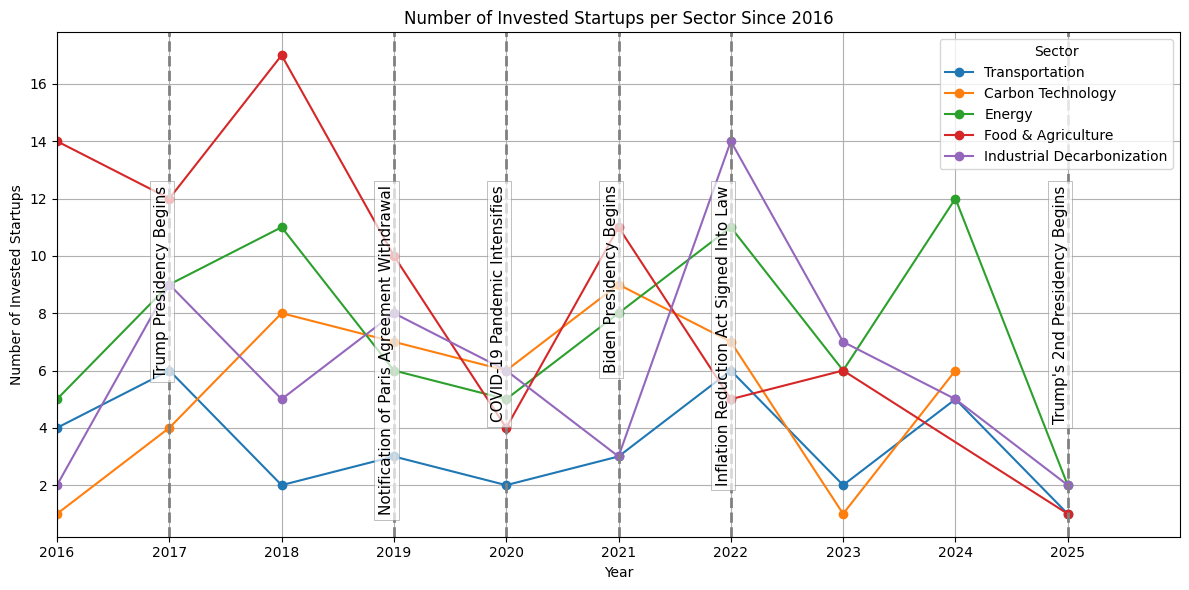

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator

startups_df['Year'] = pd.to_numeric(startups_df['Year'], errors='coerce')

plot_df = startups_df.dropna(subset=['Year', 'Sector']).copy()
plot_df['Year'] = plot_df['Year'].astype(int)
sector_counts_over_time = plot_df.groupby(['Year', 'Sector']).size().reset_index(name='Count')
unique_sectors = sector_counts_over_time['Sector'].unique()
plt.figure(figsize=(12, 6))

for sector in unique_sectors:
    sector_data = sector_counts_over_time[sector_counts_over_time['Sector'] == sector]
    plt.plot(sector_data['Year'], sector_data['Count'], marker='o', linestyle='-', label=sector)

plt.title('Number of Invested Startups per Sector Since 2016')
plt.xlabel('Year')
plt.ylabel('Number of Invested Startups')
plt.grid(True)
plt.legend(title='Sector')
plt.tight_layout()

# Set the x-axis limits to start at 2016
plt.xlim(left=2016)

years_in_data = sector_counts_over_time['Year'].unique()
years_to_show = [year for year in sorted(years_in_data) if year >= 2016]
plt.xticks(years_to_show)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

significant_events = [
    {'year': 2017, 'label': "Trump Presidency Begins"}, # Jan 20, 2017
    {'year': 2019, 'label': "Notification of Paris Agreement Withdrawal"}, #2019
    {'year': 2020, 'label': "COVID-19 Pandemic Intensifies"},  # March, 2020
    {'year': 2021, 'label': "Biden Presidency Begins"},  # Jan 20, 2021
    {'year': 2022, 'label': "Inflation Reduction Act Signed Into Law"}, #2022
    {'year': 2025, 'label': "Trump's 2nd Presidency Begins"},  # Jan 20, 2025
]

for event in significant_events:
    year = event['year']
    label = event['label']

    # Adds the vertical dotted lines
    plt.axvline(x=year, color='gray', linestyle='--', linewidth=2.0)


    y_min, y_max = plt.ylim()
    text_y_position = y_max * 0.7 # Ensures text is placed near the top of the plot

    plt.text(year, text_y_position, label,
             rotation=90,          # Rotates text for vertical alignment
             verticalalignment='top', # Aligns text to the top
             horizontalalignment='right', # Adjusts for better placement if text is wide
             color='black',
             fontsize=11, bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="gray", lw=0.5, alpha=0.7)) #adds a nice white box background to text for easier readability

plt.show()

Text(0.5, 1.0, 'Climate Startup Investment Distribution by Sector')

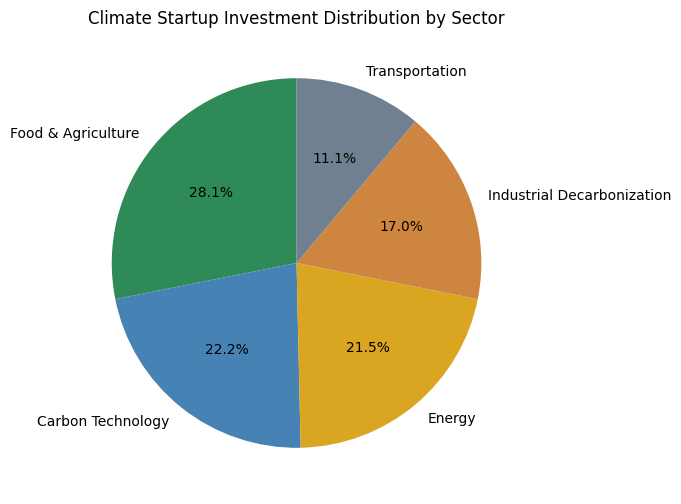

In [ ]:
sector_counts = startups_df['Sector'].value_counts()
plt.figure(figsize=(10, 6))
colors = ['#2E8B57', '#4682B4', '#DAA520', '#CD853F', '#708090']
plt.pie(sector_counts.values, labels=sector_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Climate Startup Investment Distribution by Sector')

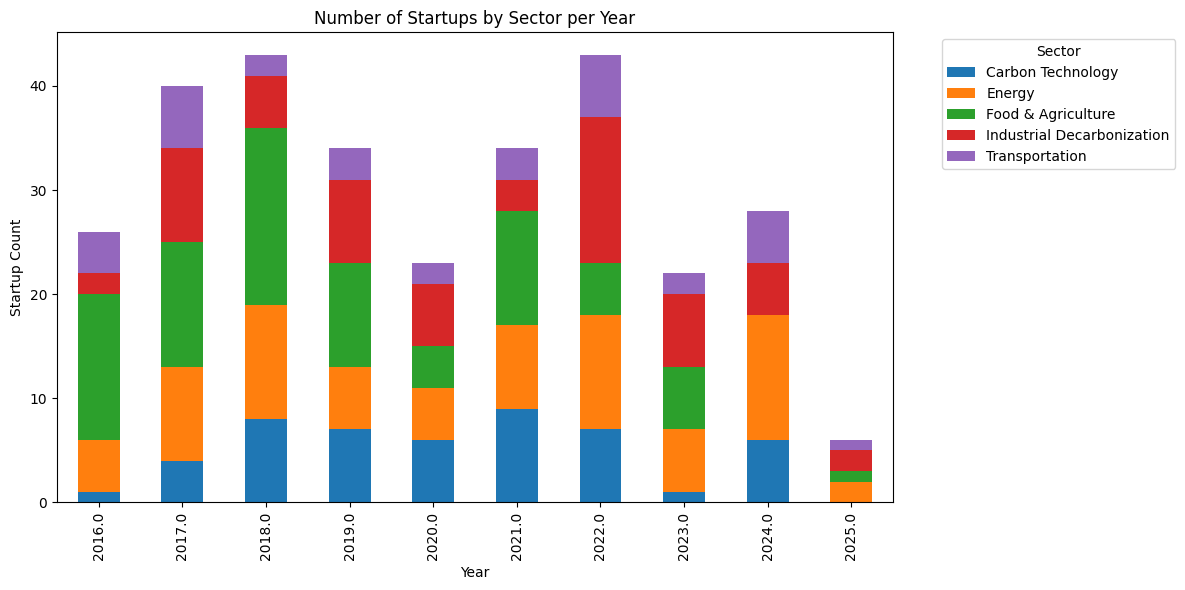

In [ ]:
yearly_counts = startups_df.groupby(['Year', 'Sector']).size().unstack().fillna(0)
yearly_counts = yearly_counts[yearly_counts.index >= 2016]
yearly_counts = yearly_counts.sort_index()
yearly_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Number of Startups by Sector per Year')
plt.xlabel('Year')
plt.ylabel('Startup Count')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

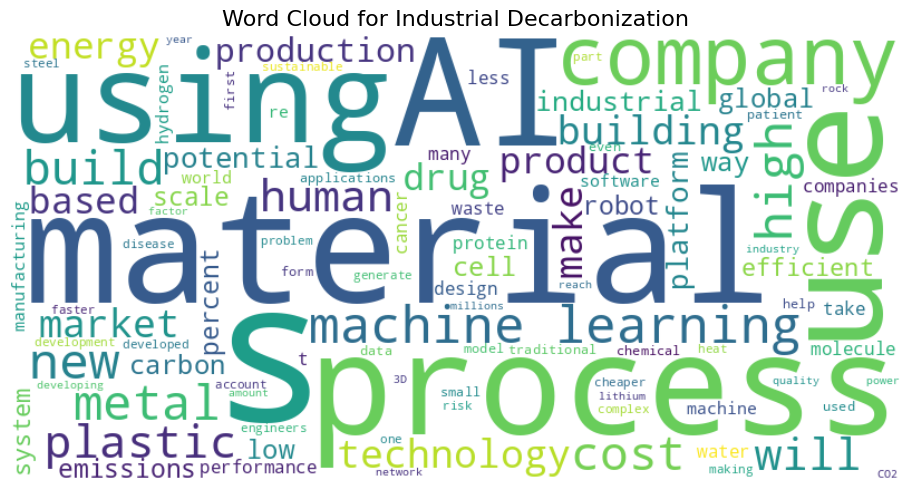

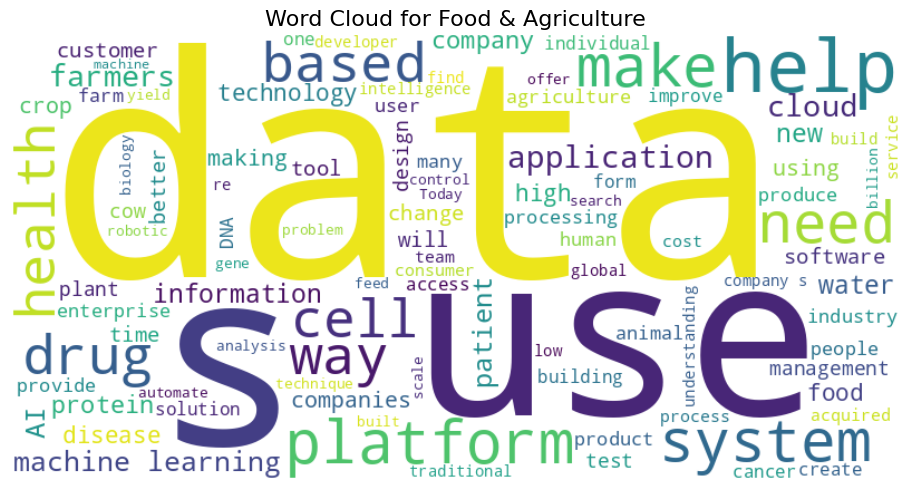

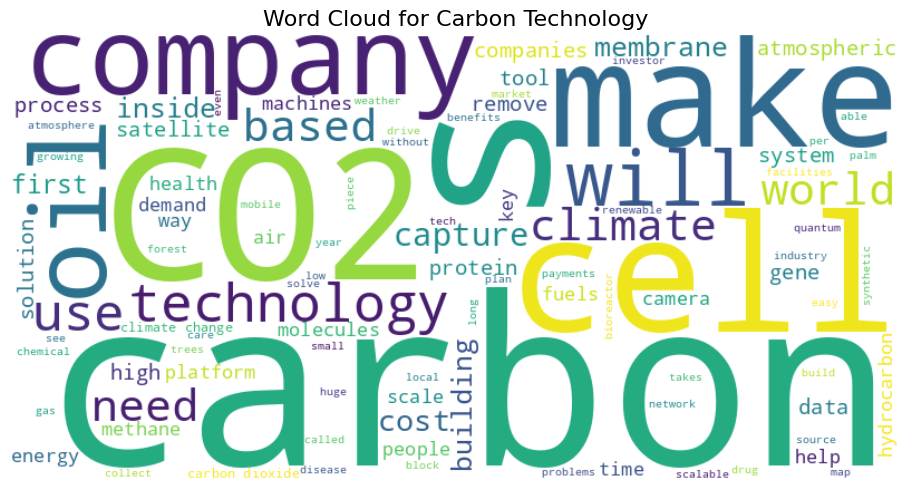

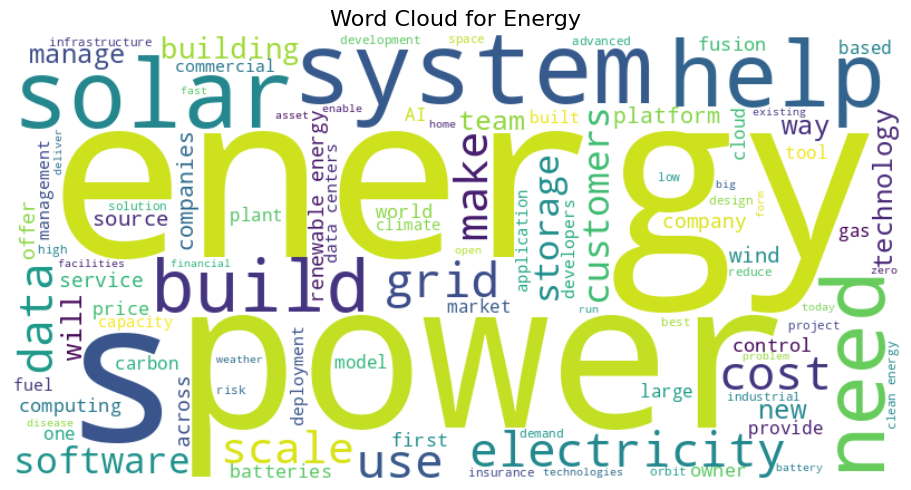

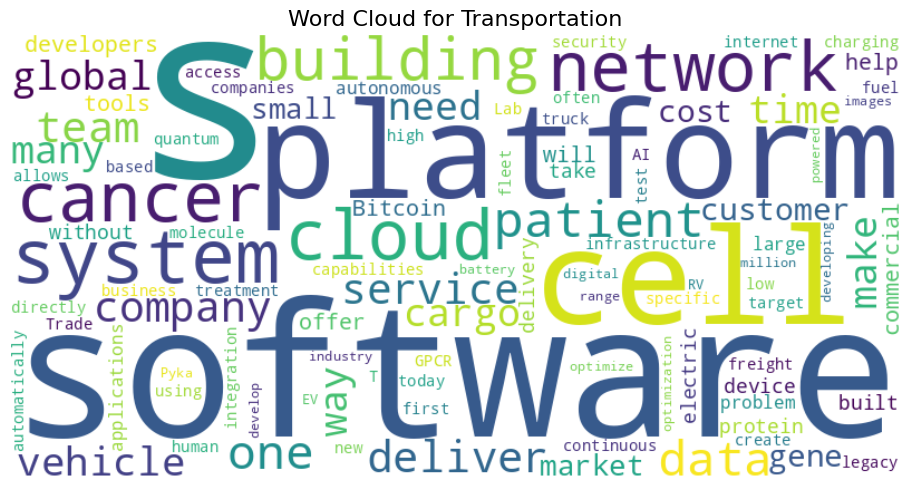

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

sector_texts = {}
for sector in startups_df['Sector'].unique():
    sector_descriptions = startups_df[startups_df['Sector'] == sector]['Description'].dropna().tolist()
    sector_texts[sector] = ' '.join(sector_descriptions)

# Generate a word cloud for each sector
for sector, text in sector_texts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sector}', fontsize=16)
    plt.tight_layout()
    plt.show()